# Import libraries

In [66]:
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import importlib.util
import sys

In [67]:
from scripts.parse_vars import parse_variables

In [68]:
path_vars = f"../../geno_simulation.txt"
R_directory = f"../../rstudio_geno_simulation"
R_file = f"create_geno.R"

variables = parse_variables(path_vars)
if 'G' not in globals():
    G = int(variables['G'])
if 'L' not in globals():
    L = int(variables['L'])
if 'c' not in globals():
    c = int(variables['c'])
if 'k' not in globals():
    k = int(variables['k'])
if 'M' not in globals():
    M = float(variables['M'])
if 'HWE' not in globals():
    HWE = int(variables['HWE'])

if 'tools' not in globals():
    tools = ['PCA', 'abyss_counted', 'abyss', 'no_corr']


if 'scenarios' not in globals():
    scenarios = ['snp_effect',
                 'linear_continuous',
                 'non_linear_continuous',
                 'discrete_global',
                 'discrete_localized',
                 'mix_linear_continuous',
                 'mix_non_linear_continuous',
                 'mix_discrete_global',
                 'mix_discrete_localized']

if 'very_rare_threshold_L' not in globals():
    very_rare_threshold_L = float(variables['very_rare_threshold_L'])
if 'very_rare_threshold_H' not in globals():
    very_rare_threshold_H = float(variables['very_rare_threshold_H'])
if 'rare_threshold_L' not in globals():
    rare_threshold_L = float(variables['rare_threshold_L'])
if 'rare_threshold_H' not in globals():
    rare_threshold_H = float(variables['rare_threshold_H'])
if 'common_threshold_L' not in globals():
    common_threshold_L = float(variables['common_threshold_L'])
if 'common_threshold_H' not in globals():
    common_threshold_H = float(variables['common_threshold_H'])
if 'F' not in globals():
    F = float(variables['F'])

# Load variables

In [69]:
path_geno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/genotype"
geno = pd.read_pickle((f"{path_geno}/complete_inbred.pkl"))

In [70]:
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/phenotype/"
pheno = pd.read_pickle(f"{path_pheno}/env_pheno.pkl")
humans = pd.read_pickle(f"{path_pheno}/inbred_humans.pkl")

In [71]:
pheno

,x,y,01_pheno_linear,02_pheno_sine_x,03_pheno_sine_y,04_pheno_sine_x_y,05_pheno_discrete
0,1,1,-1.0,0.856410,6.210526e-01,0.740260,0
1,1,1,-1.0,0.856410,6.210526e-01,0.740260,0
2,1,1,-1.0,0.856410,6.210526e-01,0.740260,0
3,1,1,-1.0,0.856410,6.210526e-01,0.740260,0
4,1,1,-1.0,0.856410,6.210526e-01,0.740260,0
...,...,...,...,...,...,...,...
1995,10,10,1.0,0.025641,-1.110223e-16,0.012987,0
1996,10,10,1.0,0.025641,-1.110223e-16,0.012987,0
1997,10,10,1.0,0.025641,-1.110223e-16,0.012987,0
1998,10,10,1.0,0.025641,-1.110223e-16,0.012987,0


In [72]:
nr_pcs = 5

In [73]:
geno_pcs = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs/geno_{nr_pcs}_PCs.pkl")
min_pcs = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs/minor_{nr_pcs}_PCs.pkl")
het_pcs = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs/het_{nr_pcs}_PCs.pkl")
maj_pcs = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/PCs/major_{nr_pcs}_PCs.pkl")


In [101]:
geno_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/geno_reconstruct_{nr_pcs}_PCs.pkl")
min_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/minor_reconstruct_{nr_pcs}_PCs.pkl")
het_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/het_reconstruct_{nr_pcs}_PCs.pkl")
maj_reconstruct = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/maf_reconstruct/major_reconstruct_{nr_pcs}_PCs.pkl")

In [102]:
error = 1-(min_reconstruct+ het_reconstruct+ maj_reconstruct)

In [103]:
#row_means = (geno_reconstruct - ((maj_reconstruct - min_reconstruct) + error)).mean(axis=0)
row_means = (geno_reconstruct - (((1-min_reconstruct-het_reconstruct) - min_reconstruct))).mean(axis=0)



In [104]:
row_means

C_1_MAF_0.500       -1.341705e-16
C_2_MAF_0.500        5.340173e-17
C_3_MAF_0.500       -3.325118e-17
C_4_MAF_0.500       -5.173639e-17
C_5_MAF_0.500       -3.788636e-17
                         ...     
VR_3996_MAF_0.043    3.608225e-18
VR_3997_MAF_0.043   -1.670886e-17
VR_3998_MAF_0.042   -4.385381e-18
VR_3999_MAF_0.042    2.498002e-17
VR_4000_MAF_0.042    1.282308e-17
Length: 4000, dtype: float64

# PCA

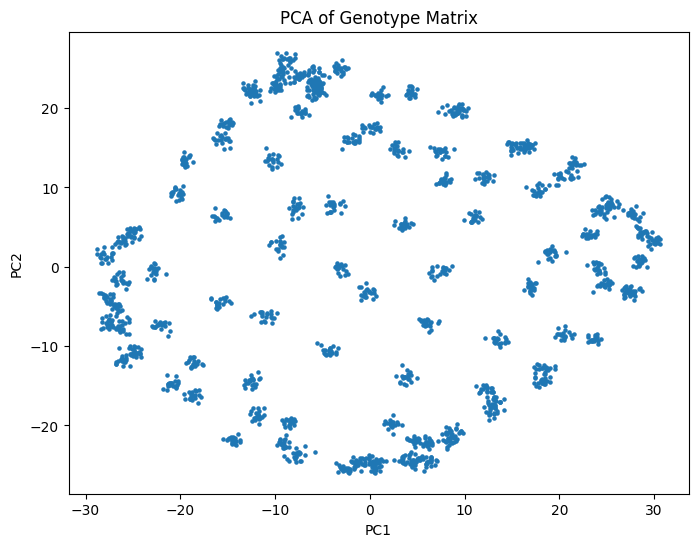

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(geno_pcs['PC1'], geno_pcs['PC2'], s=5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Genotype Matrix")
plt.show()


# Gwas

In [106]:
env_factor = "04_pheno_sine_x_y"

In [107]:
from statsmodels.api import OLS, add_constant
import numpy as np
import pandas as pd

# Extract phenotype
y = pheno[env_factor].values

# Initialize results list
results = []

# Loop through SNPs
for snp in geno.columns:
    x = geno[snp].values
    # Combine SNP with PCs
    X = pd.concat([pd.Series(x, name='SNP'), geno_pcs], axis=1)
    X = add_constant(X)  # Add intercept
    model = OLS(y, X).fit()
    pval = model.pvalues['SNP']  # p-value for SNP term
    logp = -np.log10(pval)
    results.append((snp, logp))

# Create and sort results DataFrame
gwas_results = pd.DataFrame(results, columns=['SNP', '-log10(p)'])
gwas_results = gwas_results.sort_values('-log10(p)', ascending=False).reset_index(drop=True)

# Display
gwas_results


,SNP,-log10(p)
0,C_804_MAF_0.281,89.387357
1,C_800_MAF_0.282,89.368750
2,R_1696_MAF_0.148,68.210454
3,R_1697_MAF_0.147,68.079786
4,R_1658_MAF_0.151,66.679572
...,...,...
3995,R_3109_MAF_0.063,0.001017
3996,R_2747_MAF_0.074,0.000825
3997,R_2540_MAF_0.084,0.000681
3998,R_2524_MAF_0.085,0.000388


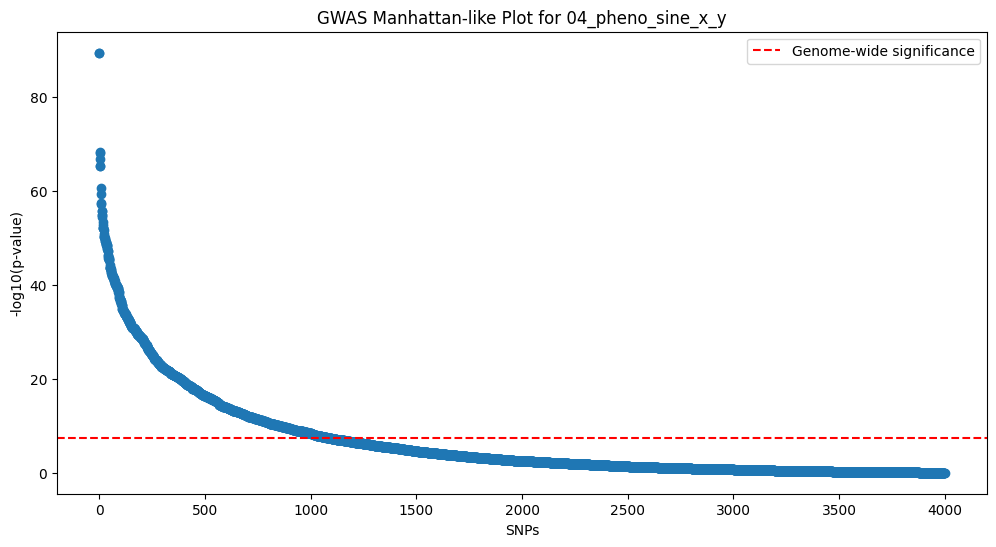

In [108]:


plt.figure(figsize=(12, 6))
plt.plot(gwas_results['-log10(p)'].values, marker='o', linestyle='none')
plt.axhline(-np.log10(5e-8), color='red', linestyle='--', label='Genome-wide significance')
plt.xlabel('SNPs')
plt.ylabel('-log10(p-value)')
plt.title(f'GWAS Manhattan-like Plot for {env_factor}')
plt.legend()
plt.show()

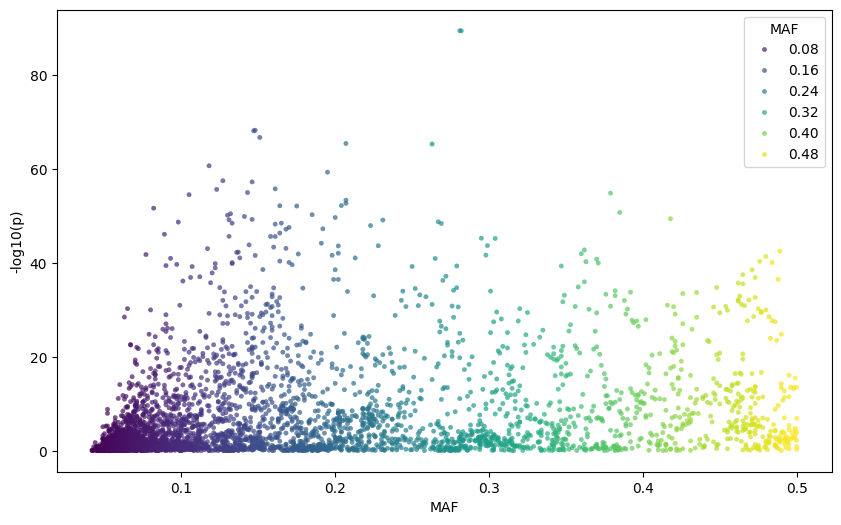

In [109]:


# Extract MAF from SNP names
gwas_results['MAF'] = gwas_results['SNP'].str.extract(r'MAF_([\d.]+)').astype(float)

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=gwas_results,
    x="MAF",
    y="-log10(p)",
    hue="MAF",
    palette="viridis",
    s=10,
    alpha=0.7,
    edgecolor=None
)


In [110]:
gwas_results['maf_deviation'] = gwas_results['SNP'].map(row_means)
gwas_results['maf_deviation_abs'] = gwas_results['maf_deviation'].abs()



In [111]:
gwas_results

,SNP,-log10(p),MAF,maf_deviation,maf_deviation_abs
0,C_804_MAF_0.281,89.387357,0.281,1.604272e-17,1.604272e-17
1,C_800_MAF_0.282,89.368750,0.282,-2.131073e-16,2.131073e-16
2,R_1696_MAF_0.148,68.210454,0.148,-7.696621e-17,7.696621e-17
3,R_1697_MAF_0.147,68.079786,0.147,2.015055e-17,2.015055e-17
4,R_1658_MAF_0.151,66.679572,0.151,2.181588e-17,2.181588e-17
...,...,...,...,...,...
3995,R_3109_MAF_0.063,0.001017,0.063,-2.636780e-17,2.636780e-17
3996,R_2747_MAF_0.074,0.000825,0.074,-2.436940e-17,2.436940e-17
3997,R_2540_MAF_0.084,0.000681,0.084,-5.384582e-18,5.384582e-18
3998,R_2524_MAF_0.085,0.000388,0.085,-2.786660e-17,2.786660e-17


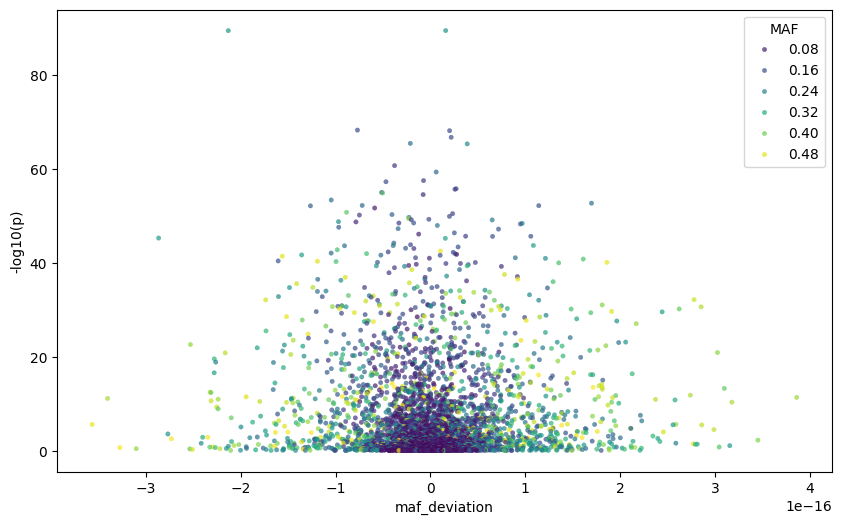

In [112]:

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=gwas_results,
    x="maf_deviation",
    y="-log10(p)",
    hue="MAF",
    palette="viridis",
    s=10,
    alpha=0.7,
    edgecolor=None
)

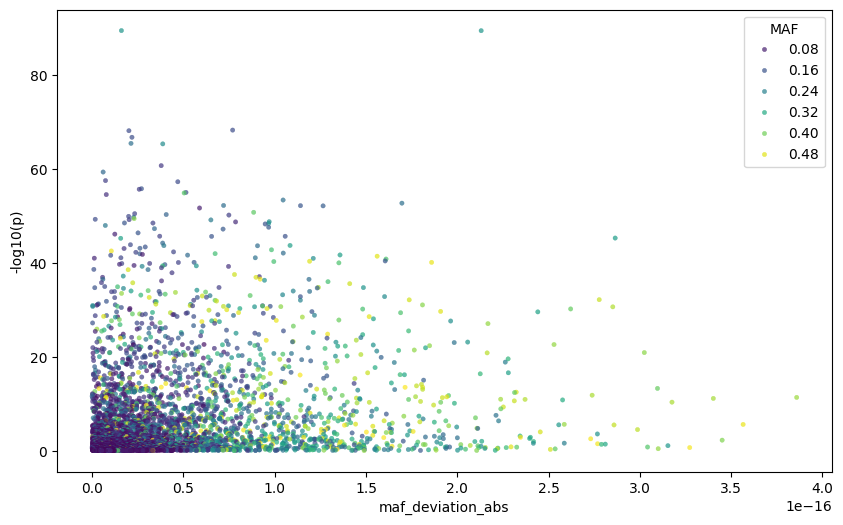

In [113]:
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=gwas_results,
    x="maf_deviation_abs",
    y="-log10(p)",
    hue="MAF",
    palette="viridis",
    s=10,
    alpha=0.7,
    edgecolor=None
)

# Showing where it goes wrong

In [87]:
geno

,C_1_MAF_0.500,C_2_MAF_0.500,C_3_MAF_0.500,C_4_MAF_0.500,C_5_MAF_0.500,C_6_MAF_0.500,C_7_MAF_0.499,C_8_MAF_0.499,C_9_MAF_0.499,C_10_MAF_0.499,...,VR_3991_MAF_0.045,VR_3992_MAF_0.044,VR_3993_MAF_0.044,VR_3994_MAF_0.044,VR_3995_MAF_0.044,VR_3996_MAF_0.043,VR_3997_MAF_0.043,VR_3998_MAF_0.042,VR_3999_MAF_0.042,VR_4000_MAF_0.042
0,1,1,-1,1,-1,-1,1,1,-1,-1,...,1,1,1,1,1,1,0,1,1,1
1,1,1,-1,1,0,0,1,1,-1,-1,...,1,1,1,1,1,1,1,1,0,1
2,1,1,-1,1,-1,-1,1,1,-1,0,...,1,1,1,1,1,1,1,1,1,1
3,1,1,-1,1,-1,-1,1,1,0,-1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,0,1,-1,-1,1,1,-1,-1,...,1,1,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1,1,1,0,1,-1,-1,1,0,0,...,1,1,1,1,0,1,1,1,1,1
1996,-1,1,1,-1,1,-1,-1,1,1,-1,...,1,1,1,0,1,1,1,1,1,1
1997,-1,1,1,-1,1,1,-1,1,1,-1,...,1,1,1,0,1,1,1,1,1,1
1998,-1,0,1,-1,1,-1,-1,1,1,-1,...,1,1,0,1,0,1,1,1,1,0


In [88]:
# Create the three new DataFrames
minor = (geno == -1).astype(int)
het = (geno == 0).astype(int)
major = (geno == 1).astype(int)


In [89]:
pcs

NameError: name 'pcs' is not defined

In [ ]:
nr_pcs = 1
pcs = pcs[:, :nr_pcs]


In [ ]:
minor

In [ ]:
# Build model
model = Sequential([
    Dense(minor.shape[1], input_shape=(pcs.shape[1],), activation='linear')
])

model.compile(optimizer=Adam(1e-3), loss='mse')

# Train model
history = model.fit(pcs, minor, epochs=100, batch_size=32, verbose=0)

# Predict on the original PCs input
predicted_minor = model.predict(pcs)

model = Sequential([
    Dense(het.shape[1], input_shape=(pcs.shape[1],), activation='linear')
])

model.compile(optimizer=Adam(1e-3), loss='mse')

# Train model
history = model.fit(pcs, het, epochs=100, batch_size=32, verbose=0)
predicted_het = model.predict(pcs)

model = Sequential([
    Dense(major.shape[1], input_shape=(pcs.shape[1],), activation='linear')
])

model.compile(optimizer=Adam(1e-3), loss='mse')

# Train model
history = model.fit(pcs, major, epochs=100, batch_size=32, verbose=0)
predicted_major = model.predict(pcs)

error = abs(1 - (predicted_major + predicted_minor + predicted_het))
mean_error = np.mean(error, axis=0)

gwas_results["mean_reconstruction_error"] = mean_error

# Plot MAF vs -log10(p)
plt.figure(figsize=(10, 6))
plt.scatter(gwas_results['mean_reconstruction_error'], gwas_results['-log10(p)'], alpha=0.5, s=8)
plt.xlabel("mean reconstruction error")
plt.ylabel("-log10(p)")
plt.title("Association Strength vs. error")
plt.grid(True)
plt.show()


In [ ]:
# Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
len(mean_error)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume gwas_results has: ['mean_reconstruction_error', '-log10(p)', 'MAF', 'SNP_ID']

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=gwas_results,
    x="mean_reconstruction_error",
    y="-log10(p)",
    hue="MAF",
    palette="viridis",
    s=10,
    alpha=0.7,
    edgecolor=None
)

# Label top 10 most significant SNPs
top_outliers = gwas_results.nlargest(10, "-log10(p)")
for _, row in top_outliers.iterrows():
    plt.text(
        row["mean_reconstruction_error"],
        row["-log10(p)"],
        row["SNP_ID"],
        fontsize=8,
        ha='right',
        va='bottom'
    )

plt.xlabel("Mean Reconstruction Error")
plt.ylabel("-log10(p)")
plt.title("Association Strength vs. Reconstruction Error")
plt.grid(True)
plt.legend(title="MAF", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
